In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

import lsst.ip.diffim as ipDiffim

In [211]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(varFlux2=np.repeat(5000, 10),
                         n_sources=1000, verbose=True, sourceFluxRange=(2000., 60000.), # psf_yvary_factor=0.5, 
                         psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: -0.0 -0.0
Variable source: 11 430.532014184 434.414017796 0 5000
Variable source: 2 427.660810318 419.100929438 0 5000
Variable source: 4 358.467452217 410.92744144 0 5000
Variable source: 8 316.562712626 116.894212295 0 5000
Variable source: 13 403.10653814 219.668213309 0 5000
Variable source: 1 387.709867276 181.352731522 0 5000
Variable source: 0 127.628652422 282.460928881 0 5000
Variable source: 6 343.291765499 352.648316392 0 5000
Variable source: 5 171.4583324 209.804682288 0 5000
Variable source: 3 193.456129542 274.216491496 0 5000
{'ZOGY': {'FP': 0, 'FN': 1, 'TP': 9}, 'ALstack': {'FP': 2, 'FN': 1, 'TP': 9}, 'SZOGY': {'FP': 0, 'FN': 1, 'TP': 9}, 'ALstack_decorr': {'FP': 0, 'FN': 1, 'TP': 9}}


A&L(dec): stats(mean=0.10756084, stdev=24.829136, min=-156.81978, max=305.21878)
ZOGY: stats(mean=0.034286071343695469, stdev=24.895724834932668, min=-294.56608608114988, max=306.91676638516509)
A&L(dec) - ZOGY: stats(mean=0.05624706773968937, stdev=1.9162654424611598, min=-38.139580117922563, max=90.363002047200411)
A&L(dec) - A&L: stats(mean=-0.03747277, stdev=6.8879108, min=-39.329117, max=51.057953)


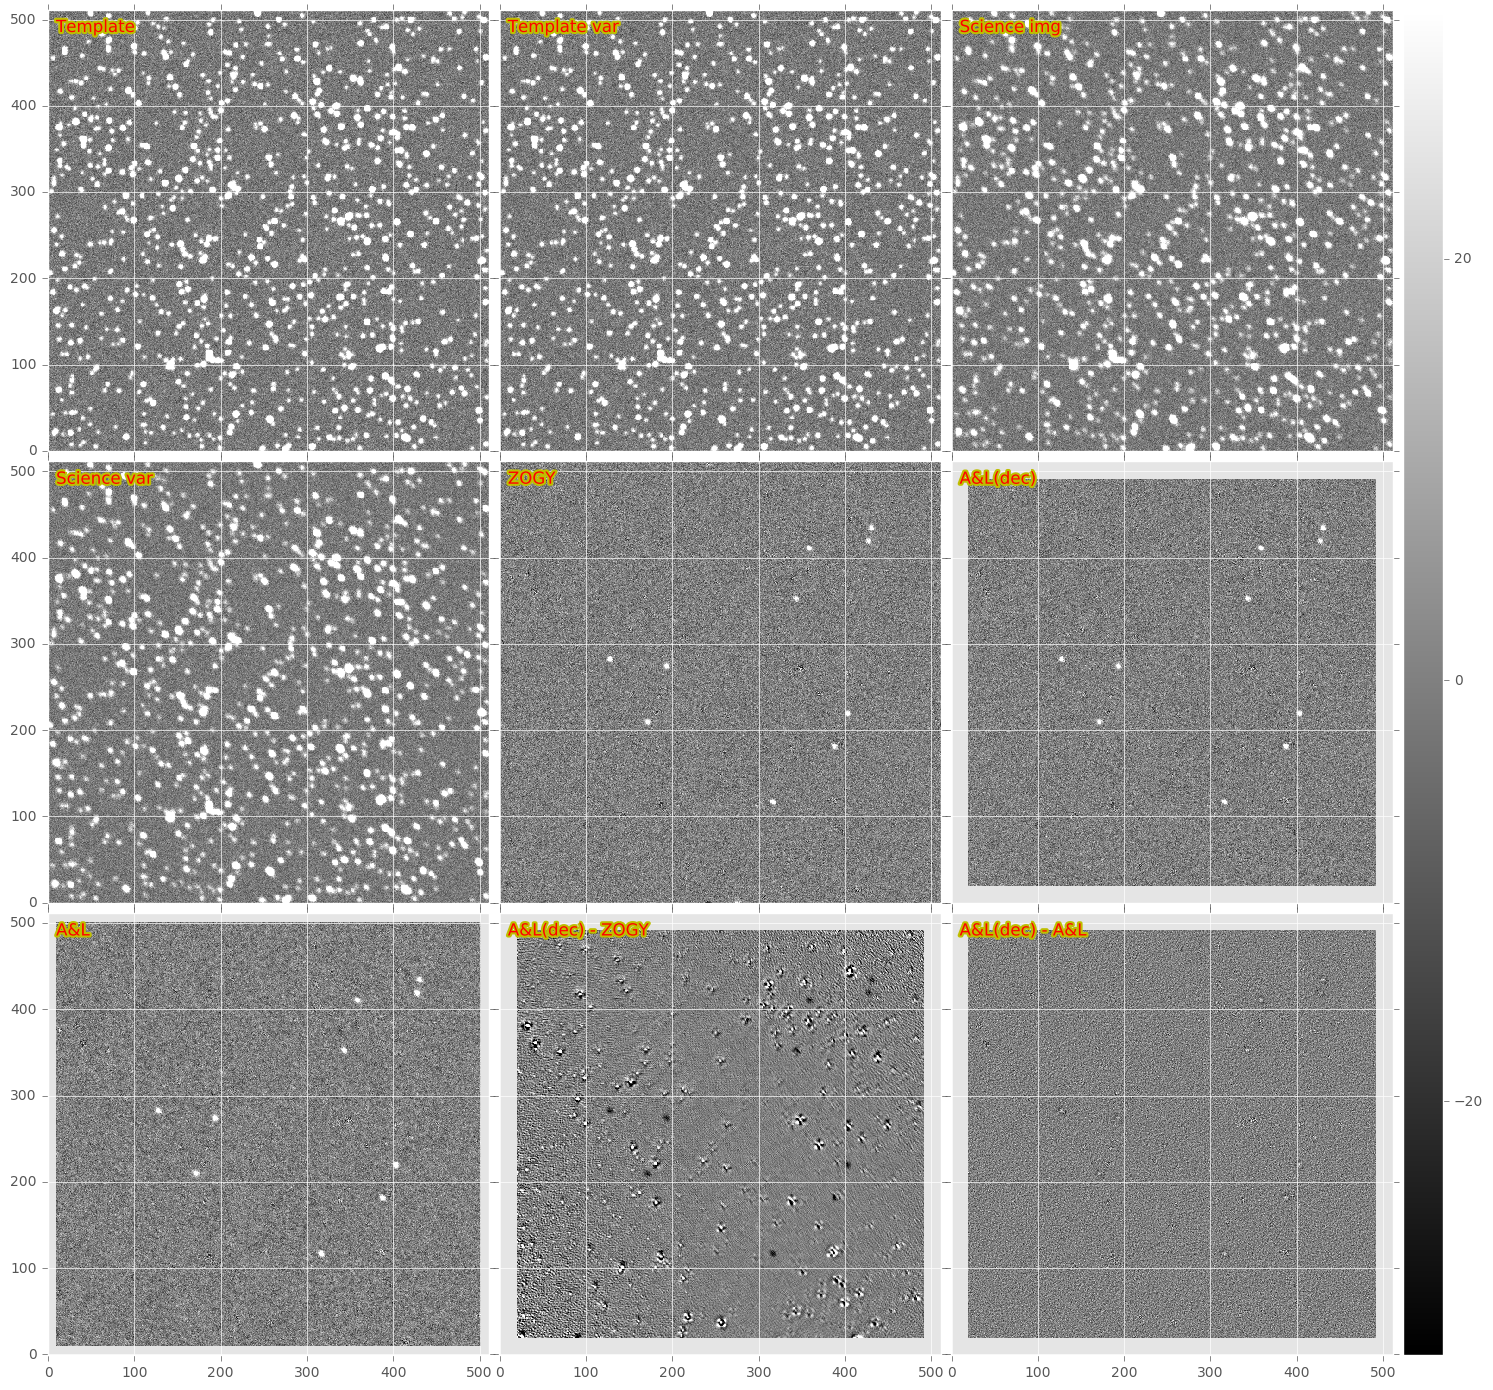

In [212]:
#dit.plotImageGrid((testObj.im1.im, testObj.im2.im), imScale=8)
testObj.doPlot(imScale=6);

In [213]:
exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

OK, let's try a spatially-varying ZOGY! But without correctly setting the (spatially varying) PSF of the diffim.

In [214]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

class ZogyMapperSubtask(ipDiffim.ImageMapperSubtask):
    ConfigClass = ipDiffim.ImageMapperSubtaskConfig
    _DefaultName = 'ip_diffim_ZogyMapperSubtask'
    
    def __init__(self, *args, **kwargs):
        ipDiffim.ImageMapperSubtask.__init__(self, *args, **kwargs)
        
    def run(self, subExp, expandedSubExp, fullBBox, **kwargs):
        bbox = subExp.getBBox()
        center = ((bbox.getBeginX() + bbox.getEndX()) // 2., (bbox.getBeginY() + bbox.getEndY()) // 2.)
        center = afwGeom.Point2D(center[0], center[1])
        
        #print center, subExp.getBBox(), expandedSubExp.getBBox()
        
        # Psf and image for science img (index 2)
        subExp2 = subExp
        psf2 = subExp.getPsf().computeImage(center).getArray()
        psf2_orig = psf2
        subim2 = expandedSubExp.getMaskedImage()
        subarr2 = subim2.getImage().getArray()
        subvar2 = subim2.getVariance().getArray()
        sig2 = np.sqrt(dit.computeClippedImageStats(subvar2).mean)
        
        # Psf and image for template img (index 1)
        template = kwargs.get('template')
        subExp1 = afwImage.ExposureF(template, expandedSubExp.getBBox())
        psf1 = template.getPsf().computeImage(center).getArray()
        psf1_orig = psf1
        subim1 = subExp1.getMaskedImage()
        subarr1 = subim1.getImage().getArray()
        subvar1 = subim1.getVariance().getArray()
        sig1 = np.sqrt(dit.computeClippedImageStats(subvar1).mean)
        
        #shape2 = subExp2.getPsf().computeShape(afwGeom.Point2D(center[0], center[1]))
        #shape1 = subExp1.getPsf().computeShape(afwGeom.Point2D(center[0], center[1]))
        #print shape2, shape1
        
        psf1b = psf1; psf2b = psf2
        if psf1.shape[0] == 41:   # it's a measured psf (hack!) Note this really helps for measured psfs.
            psf1b = psf1.copy()
            psf1b[psf1b < 0] = 0
            #psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b[0:10,:] = psf1b[:,0:10] = psf1b[31:41,:] = psf1b[:,31:41] = 0
            psf1b /= psf1b.sum()

            psf2b = psf2.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,:] = psf2b[:,0:10] = psf2b[31:41,:] = psf2b[:,31:41] = 0
            psf2b /= psf2b.sum()

        # from diffimTests.diffimTests ...
        padSize0 = subarr1.shape[0]//2 - psf1.shape[0]//2
        padSize1 = subarr1.shape[1]//2 - psf1.shape[1]//2
        # Hastily assume the image is even-sized and the psf is odd... and that the two images
        #   and psfs have the same dimensions!
        psf1 = np.pad(psf1b, ((padSize0, padSize0-1), (padSize1, padSize1-1)), mode='constant',
                      constant_values=0)
        psf2 = np.pad(psf2b, ((padSize0, padSize0-1), (padSize1, padSize1-1)), mode='constant',
                      constant_values=0)
        if psf1.shape[0] > subarr1.shape[0]:
            psf1 = psf1[:-1, :]
            psf2 = psf2[:-1, :]
        elif psf1.shape[0] < subarr1.shape[0]:
            psf1 = np.pad(psf1, ((0, 1), (0, 0)), mode='constant', constant_values=0)
            psf2 = np.pad(psf2, ((0, 1), (0, 0)), mode='constant', constant_values=0)
        if psf1.shape[1] > subarr1.shape[1]:
            psf1 = psf1[:, :-1]
            psf2 = psf2[:, :-1]
        elif psf1.shape[1] < subarr1.shape[1]:
            psf1 = np.pad(psf1, ((0, 0), (0, 1)), mode='constant', constant_values=0)
            psf2 = np.pad(psf2, ((0, 0), (0, 1)), mode='constant', constant_values=0)
        #psf1 = dit.psf.recenterPsf(psf1)
        #psf2 = dit.psf.recenterPsf(psf2)
        psf1 /= psf1.sum()
        psf2 /= psf2.sum()
        
        #shape2 = dit.arrayToAfwPsf(psf2).computeShape(afwGeom.Point2D(center[0], center[1]))
        #shape1 = dit.arrayToAfwPsf(psf1).computeShape(afwGeom.Point2D(center[0], center[1]))
        #print center, shape2, shape1

        D_zogy, var_zogy = dit.zogy.performZOGY(subarr1, subarr2,
                                                subvar1, subvar2,
                                                psf1, psf2, 
                                                sig1=sig1, sig2=sig2)
        
#         D_zogy, var_zogy = dit.zogy.performZOGYImageSpace(subarr1, subarr2,
#                                                           subvar1, subvar2,
#                                                           psf1, psf2, 
#                                                           sig1=sig1, sig2=sig2, padSize=15)
        tmpExp = expandedSubExp.clone()
        tmpIM = tmpExp.getMaskedImage()
        tmpIM.getImage().getArray()[:, :] = D_zogy
        tmpIM.getVariance().getArray()[:, :] = var_zogy
        # need to eventually compute diffim PSF and set it here.
        out = afwImage.ExposureF(tmpExp, subExp.getBBox())
                
        #print template
        #img += 10.
        return out #, psf1_orig, psf2_orig
    
class ZogyMapReduceConfig(ipDiffim.ImageMapReduceConfig):
    mapperSubtask = pexConfig.ConfigurableField(
        doc='Zogy subtask to run on each sub-image',
        target=ZogyMapperSubtask
    )

In [215]:
config = ZogyMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
#config.borderSizeX = config.borderSizeY = 10
config.reducerSubtask.reduceOperation = 'average'
task = ipDiffim.ImageMapReduceTask(config=config)
print config
boxes0, boxes1 = task._generateGrid(exposure)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 5.0, 'borderSizeY': 5.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [216]:
newExp = task.run(exposure, template=template)

stats(mean=5.4769239, stdev=20.950058, min=-82.0, max=2745.0)
stats(mean=0.00014759805, stdev=24.914509, min=-503.5141, max=307.03287)
stats(mean=2.6459222, stdev=10.217236, min=-50.032867, max=2707.9746)
stats(mean=1.5458994227412099e-05, stdev=0.01039221844807074, min=-478.63415574517364, max=306.45682945362108)


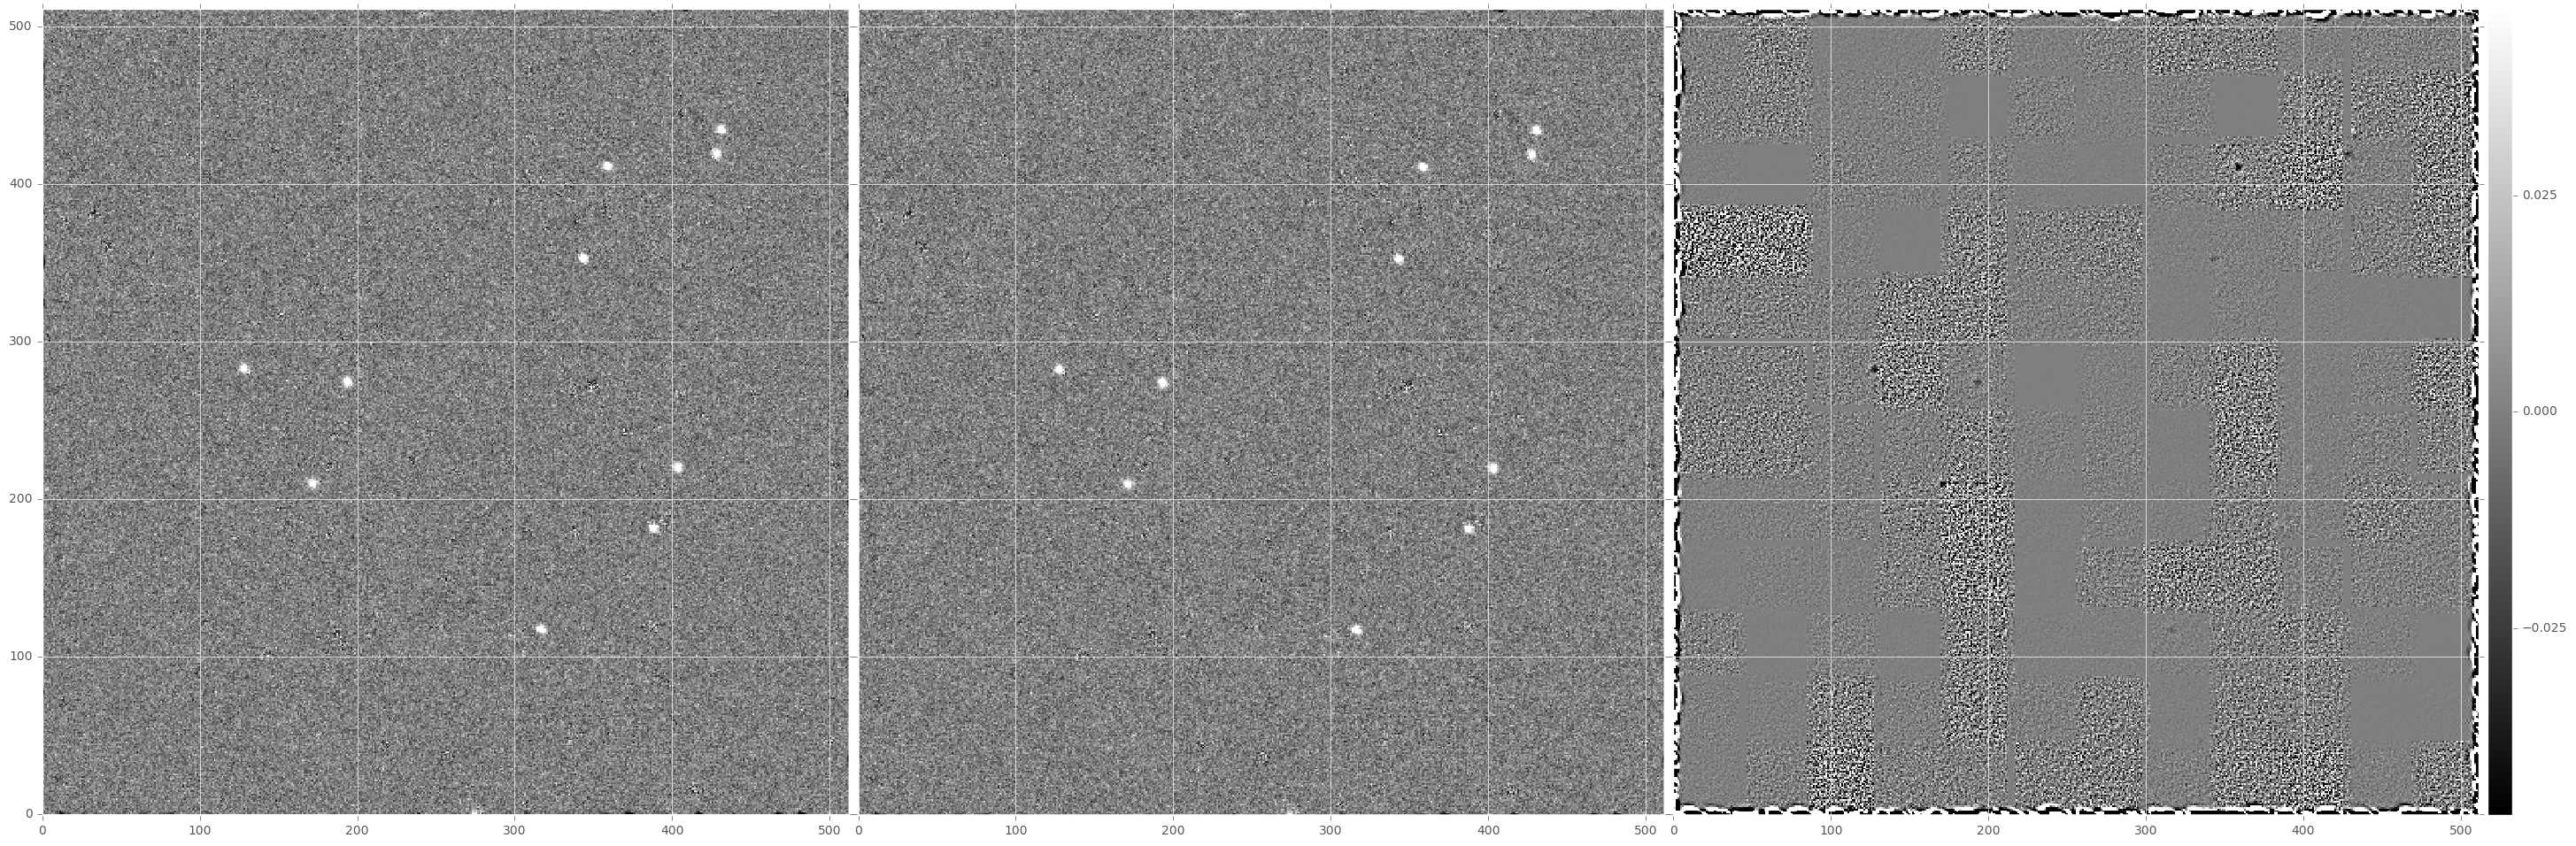

In [217]:
print dit.computeClippedImageStats(ga(exposure))
print dit.computeClippedImageStats(ga(newExp))
print dit.computeClippedImageStats(ga(exposure)-ga(newExp))
print dit.computeClippedImageStats(ga(newExp) - testObj.D_ZOGY.im)
dit.plotImageGrid((ga(newExp), newExp.getMaskedImage().getImage(), ga(newExp) - testObj.D_ZOGY.im), imScale=12)

### Try to figure out the apperent offset, look at a specific subimage containing one of the "transients"...

In [177]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()

In [180]:
import lsst.afw.geom as afwGeom
centroid = afwGeom.Point2I(210, 146) #216, 392)
ind = 0
for box in task.boxes0:
    if box.contains(centroid):
        break
    ind += 1
print ind, task.boxes0[ind], task.boxes1[ind]

51 Box2I((170, 128), (216, 174)) Box2I((147, 105), (239, 197))


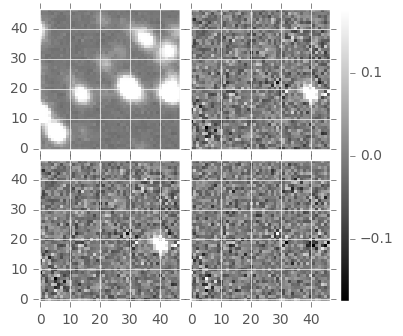

In [181]:
subExp = afwImage.ExposureF(exposure, task.boxes0[ind])
expandedSubExp = afwImage.ExposureF(exposure, task.boxes1[ind])
result = task.mapperSubtask.run(subExp, expandedSubExp, exposure.getBBox(), template=template)
ZOGYsub = afwImage.ExposureF(testObj.D_ZOGY.asAfwExposure(), task.boxes0[ind])
dit.plotImageGrid((ga(subExp), ga(result), ga(ZOGYsub), ga(result)-ga(ZOGYsub)))

(209, 381)
(0.0, 0.0) (-4.6837533851373822e-17, -2.2204460492503146e-16)
(5.5511151231257815e-17, 0.0) (-1.157927920214519e-16, 0.0)


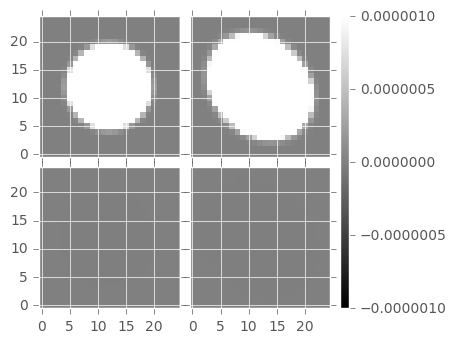

In [168]:
bbox = subExp.getBBox()
center = ((bbox.getBeginX() + bbox.getEndX()) // 2., (bbox.getBeginY() + bbox.getEndY()) // 2.)
center = afwGeom.Point2D(center[0], center[1])
print center
psf1 = template.getPsf().computeImage(center).getArray()
psf2 = exposure.getPsf().computeImage(center).getArray()
print dit.psf.computeMoments(psf1), dit.psf.computeMoments(psf2)
print dit.psf.computeMoments(testObj.im1.psf), dit.psf.computeMoments(testObj.im2.psf)
dit.plotImageGrid((psf1, psf2, psf1-testObj.im1.psf, psf2-testObj.im2.psf), clim=(-0.000001, 0.000001))

(92, 92) (93, 93)
(1.0000000000000002, 0.99999999999999989) (1.0000000000000002, 0.99999999999999989)


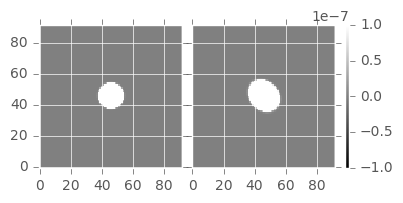

In [182]:
psf1 = template.getPsf().computeImage(center).getArray()
psf2 = exposure.getPsf().computeImage(center).getArray()
subarr1 = expandedSubExp.getMaskedImage().getImage().getArray()

padSize0 = subarr1.shape[0]//2 - psf1.shape[0]//2
padSize1 = subarr1.shape[1]//2 - psf1.shape[1]//2

psf1 = np.pad(psf1, ((padSize0, padSize0-1), (padSize1, padSize1-1)), mode='constant',
                      constant_values=0)
psf2 = np.pad(psf2, ((padSize0, padSize0-1), (padSize1, padSize1-1)), mode='constant',
                      constant_values=0)
print psf1.shape, subarr1.shape
print dit.psf.computeMoments(psf1), dit.psf.computeMoments(psf2)
dit.plotImageGrid((psf1, psf2), clim=(-0.0000001, 0.0000001))

(93, 93) (93, 93)
(-1.6425450741315651e-17, -1.1102230246251565e-16) (2.7755575615628932e-17, 5.5511151231257864e-17)


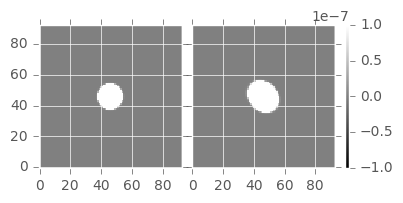

In [183]:
if psf1.shape[0] > subarr1.shape[0]:
    psf1 = psf1[:-1, :]
    psf2 = psf2[:-1, :]
elif psf1.shape[0] < subarr1.shape[0]:
    psf1 = np.pad(psf1, ((0, 1), (0, 0)), mode='constant', constant_values=0)
    psf2 = np.pad(psf2, ((0, 1), (0, 0)), mode='constant', constant_values=0)
if psf1.shape[1] > subarr1.shape[1]:
    psf1 = psf1[:, :-1]
    psf2 = psf2[:, :-1]
elif psf1.shape[1] < subarr1.shape[1]:
    psf1 = np.pad(psf1, ((0, 0), (0, 1)), mode='constant', constant_values=0)
    psf2 = np.pad(psf2, ((0, 0), (0, 1)), mode='constant', constant_values=0)

print psf1.shape, subarr1.shape
print dit.psf.computeMoments(psf1), dit.psf.computeMoments(psf2)
dit.plotImageGrid((psf1, psf2), clim=(-0.0000001, 0.0000001))

### re-do with measured psfs...

In [218]:
exposure2 = testObj.im2.asAfwExposure()
res = dit.tasks.doMeasurePsf(exposure2, spatialOrder=1)
psf = res.psf
exposure2.setPsf(psf)

template2 = testObj.im1.asAfwExposure()
res = dit.tasks.doMeasurePsf(template2, spatialOrder=1)
psf = res.psf
template2.setPsf(psf)

In [219]:
print testObj.im1.psf.shape, testObj.im2.psf.shape
print testObj.im1.asAfwExposure().getPsf().computeImage().getArray().shape
print testObj.im2.asAfwExposure().getPsf().computeImage().getArray().shape
print exposure2.getPsf().computeImage().getArray().shape
print template2.getPsf().computeImage().getArray().shape

print testObj.im1.sig, testObj.im2.sig

(25, 25) (25, 25)
(25, 25)
(25, 25)
(41, 41)
(41, 41)
17.4090355934 17.4778981532


4.38019431513e-05 3.15136466101e-05 3.61191195552e-05 2.40052418454e-05


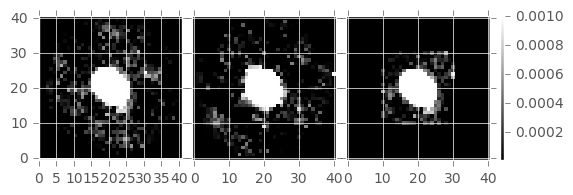

In [220]:
import lsst.afw.geom as afwGeom
psf = exposure2.getPsf()

psf1 = psf.computeImage(afwGeom.Point2D(20., 20.)).getArray()
psf1b = psf1.copy()
psf1b[psf1b < 0] = 0
print psf1b[0:10,:].mean(), psf1b[:,0:10].mean(), psf1b[31:41,:].mean(), psf1b[:,31:41].mean()
psf1b[0:10,:] = psf1b[:,0:10] = psf1b[31:41,:] = psf1b[:,31:41] = 0
psf1b /= psf1b.sum()

dit.plotImageGrid((psf.computeImage(afwGeom.Point2D(20., 20.)), psf.computeImage(afwGeom.Point2D(500.,500.)), psf1b),
                 clim=(0.00001, 0.001))

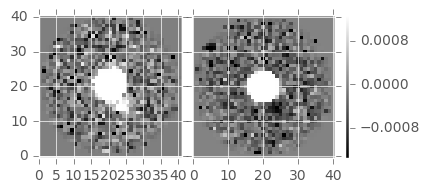

In [221]:
psf = template2.getPsf()
dit.plotImageGrid((psf.computeImage(afwGeom.Point2D(20., 20.)), psf.computeImage(afwGeom.Point2D(500.,500.))))

In [222]:
config = ZogyMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
#config.borderSizeX = config.borderSizeY = 10
config.reducerSubtask.reduceOperation = 'average'
task = ipDiffim.ImageMapReduceTask(config=config)
print config

newExp2 = task.run(exposure2, template=template2)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 5.0, 'borderSizeY': 5.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


stats(mean=-0.52307612, stdev=20.950056, min=-88.0, max=2739.0)
stats(mean=0.00014759805, stdev=24.914509, min=-503.5141, max=307.03287)
stats(mean=-0.98217404, stdev=25.042273, min=-461.03076, max=293.04276)
stats(mean=2.3075566, stdev=28.205448, min=-290.04276, max=2682.6919)
stats(mean=1.5458994227412099e-05, stdev=0.01039221844807074, min=-478.63415574517364, max=306.45682945362108)
stats(mean=-1.0623835659383254, stdev=26.511408677129978, min=-467.56902798119665, max=291.62842383495348)
stats(mean=1.0150256, stdev=26.497889, min=-354.7124, max=330.26086)


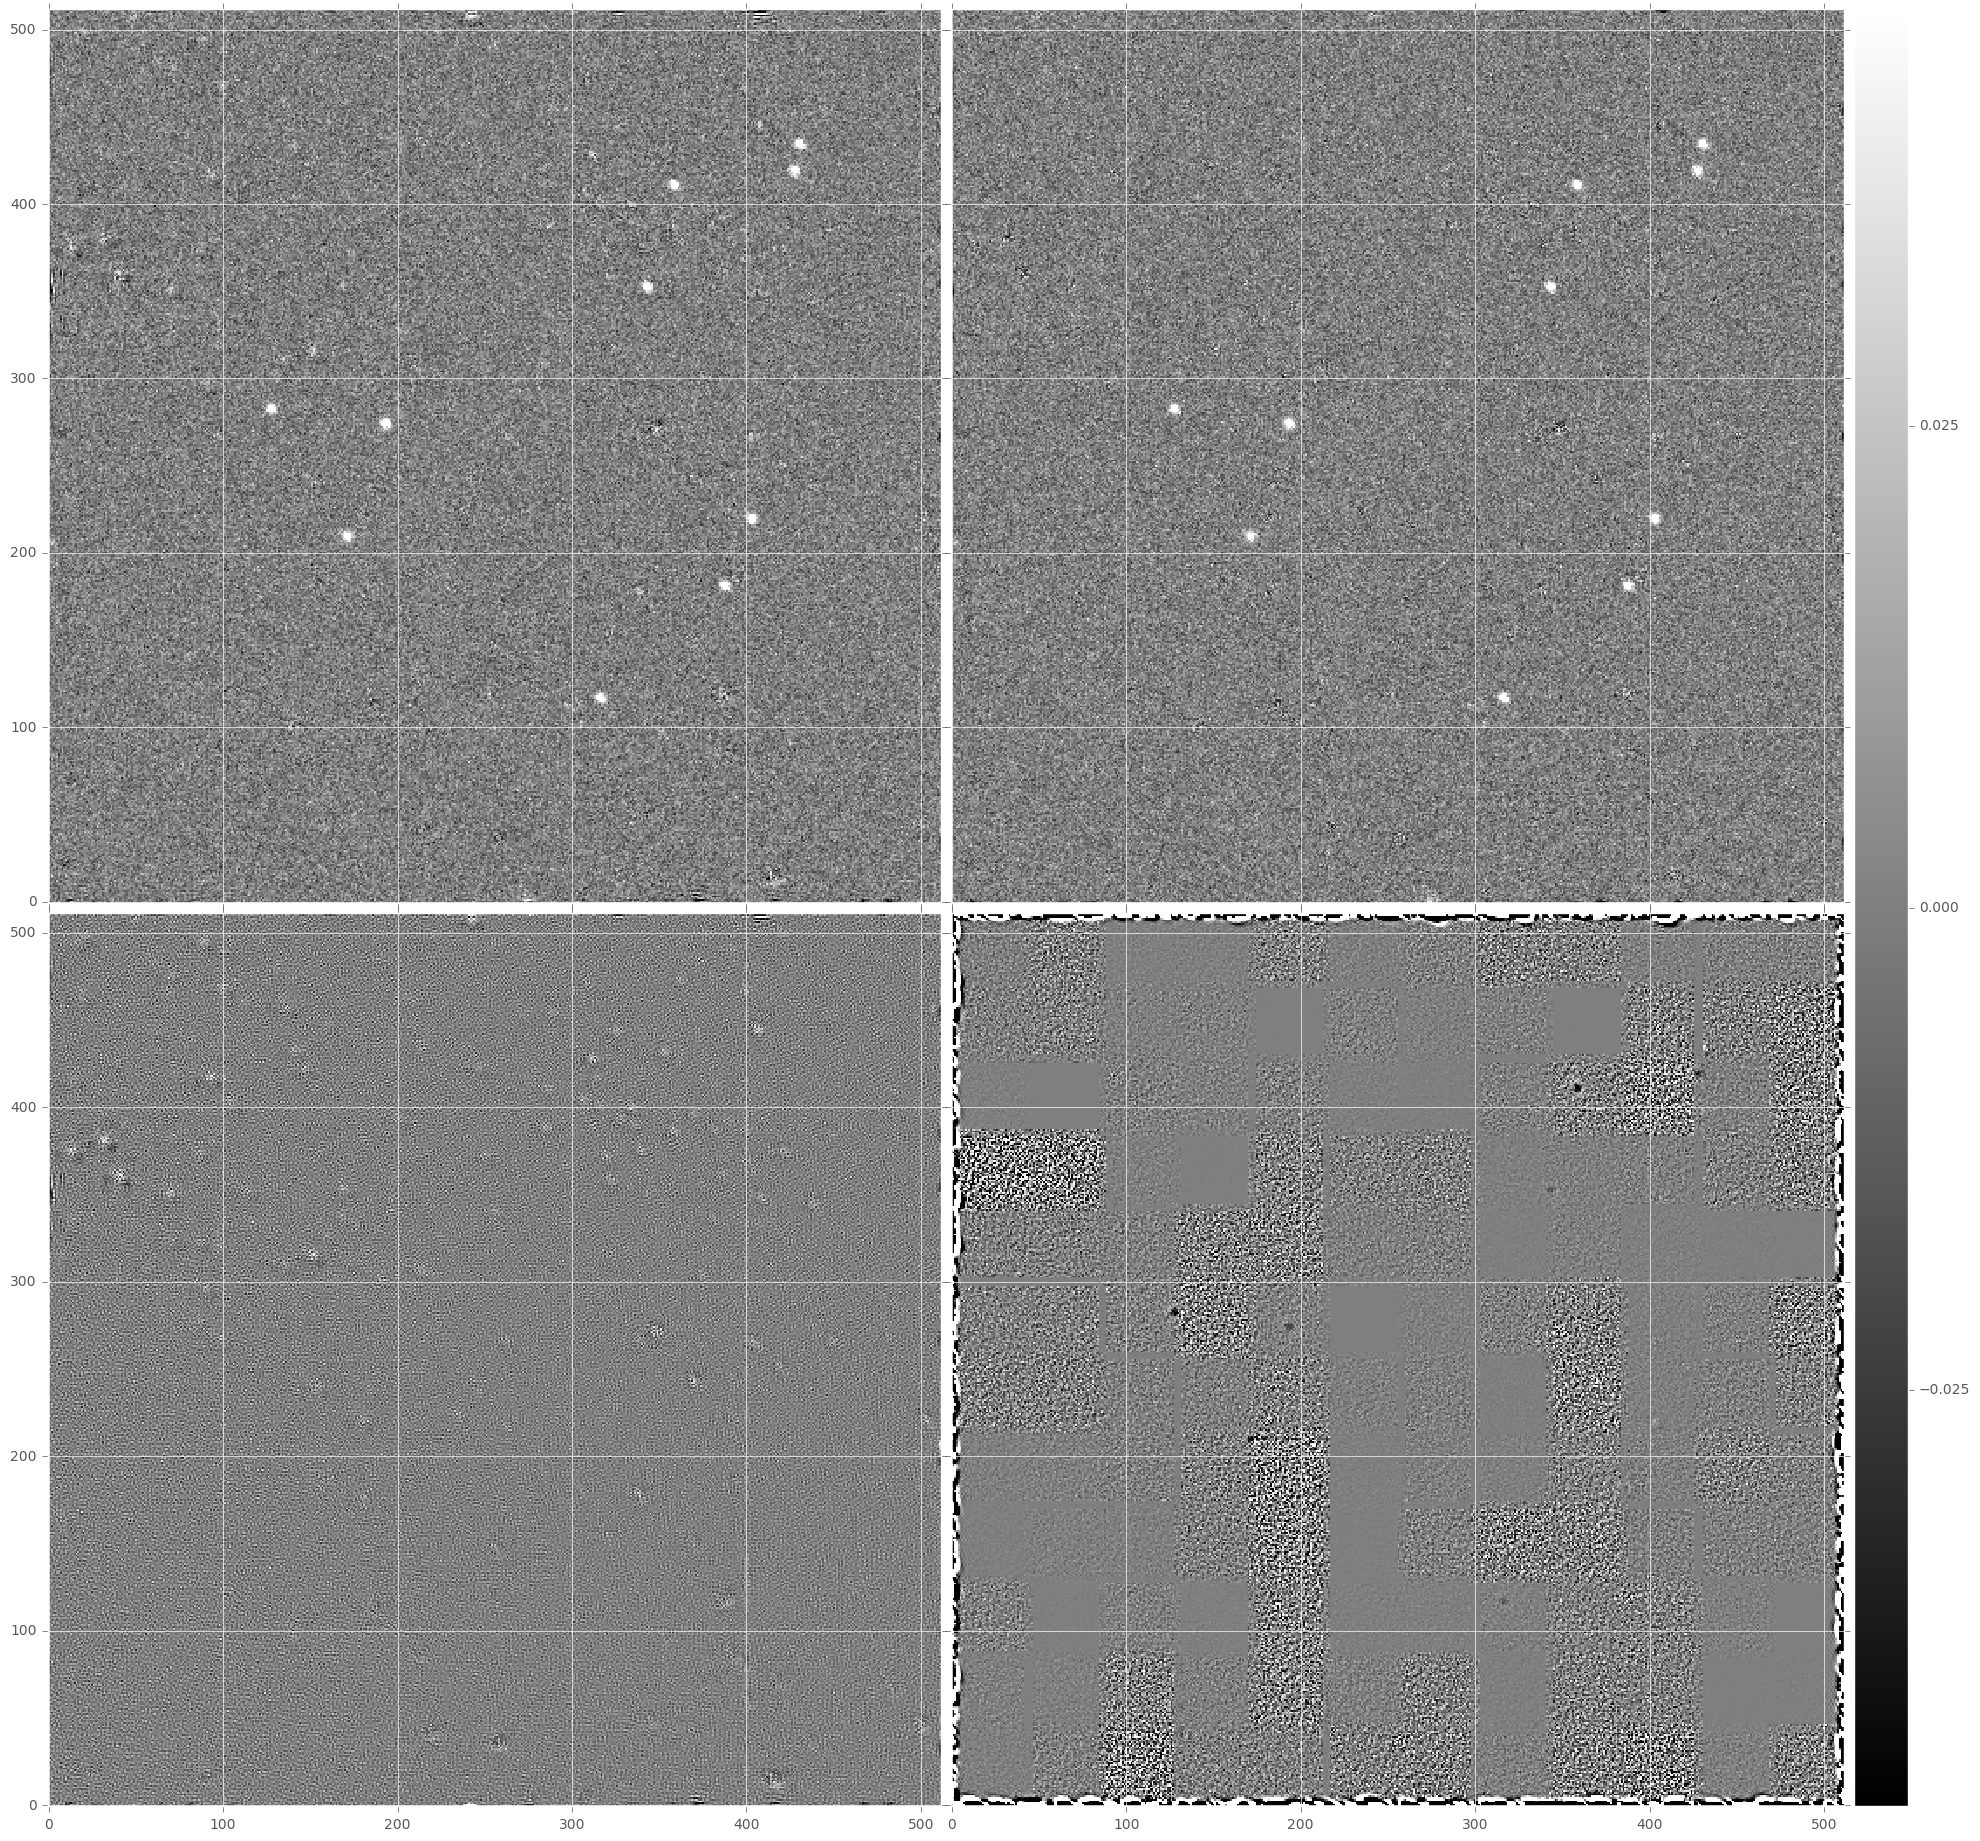

In [223]:
print dit.computeClippedImageStats(ga(exposure2))
print dit.computeClippedImageStats(ga(newExp))
print dit.computeClippedImageStats(ga(newExp2))
print dit.computeClippedImageStats(ga(exposure2)-ga(newExp2))
print dit.computeClippedImageStats(ga(newExp) - testObj.D_ZOGY.im)
print dit.computeClippedImageStats(ga(newExp2) - testObj.D_ZOGY.im)
print dit.computeClippedImageStats(ga(newExp) - ga(newExp2))
dit.plotImageGrid((ga(newExp2), ga(newExp), ga(newExp2) - testObj.D_ZOGY.im,
                  ga(newExp) - testObj.D_ZOGY.im), imScale=12)

Note this seems to have worked with `n_sources=1000` and thus more accurately measured PSFs, but with `n_sources=2000`, the result is not as nice!